<a href="https://colab.research.google.com/github/joamho-luiz/Trabalho-FMC/blob/main/Gr%C3%A1fico_Estimativa_Temperatura.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Esse código se pretende gerar uma imagem comparando a curva da estimativa histórica de temperatura de um modelo climático em relação a curva da estimativa histórica de temperatura do GISS_TEMP (NASA).

# Instações e Importações

In [ ]:
!pip install --upgrade  xarray zarr gcsfs cftime nc-time-axis 
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs
from matplotlib.axes import Axes
xr.set_options(display_style='html')
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 
plt.rcParams['figure.figsize'] = 12, 6
fig = plt.figure(figsize=(15, 8))

# Funções

In [2]:
def temperatura(mod):
  pd_tas_timeseries=mod.tas.to_pandas() # Transformando xarray para pandas
  tasm=pd_tas_timeseries.loc['1951-01':'1980-12'].mean() #Calculando a média de 1950 até 1980 como no GISS_TEMP
  return tasm # Temperatura média do modelo
def anomalias(mod):
  pd_tas_timeseries=mod.tas.to_pandas()
  pd_atas_timeseries=pd_tas_timeseries- temperatura(mod)
  ano=pd_atas_timeseries.resample("1y").median()
  yys=ano.reset_index()
  ys=yys[0] #separa a TAS
  tempo=yys['time'] #separa a data
  xx=tempo.to_list() #coloca em uma lista
  xs=np.int16([date.strftime("%Y") for date in xx]).tolist() #pegue apenas o ano e ignore o dia e mês
  plt.plot(xs, ys, label='NUIST')

####

def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'time'}
    return (ds * weight).mean(other_dims)

def busca(y):
  modelo_tas = modelos.query(y)
  return modelo_tas

####

def media12(par):

  gcs = gcsfs.GCSFileSystem(token='anon')
  modelo=busca(par)
  zstore = modelo.zstore.values[0]
  mapper = gcs.get_mapper(zstore)
  ds = xr.open_zarr(mapper, consolidated=True)
  df=ds.tas.to_dataframe()
  G= global_mean(ds) - 273
  #plt.plot(G.time, G.tas)
  Med12= G.rolling(time=12).mean()
  #plt.plot(Med12.time, Med12.tas)
  return Med12

#######

def america(mod):
  ds= mod
  min_lon = -88.0
  min_lat = -60.0
  max_lon = -30.0
  max_lat = 14
  min_lon = min_lon+360
  max_lon = max_lon+360
  mask_lon = (ds.lon >= min_lon) & (ds.lon <= max_lon)
  mask_lat = (ds.lat >= min_lat) & (ds.lat <= max_lat)
  ams_tair = ds.tas.where(mask_lon & mask_lat, drop=True)
  return ams_tair

def america12(t):
  ds=america(t)
  G= global_mean(ds) - 273
  #plt.plot(G.time, G.tas)
  Med12= G.rolling(time=12).mean()
  #plt.plot(Med12.time, Med12.tas)
  return Med12  

####

def mapa(par):

  gcs = gcsfs.GCSFileSystem(token='anon')
  modelo=busca(par)
  zstore = modelo.zstore.values[0]
  mapper = gcs.get_mapper(zstore)
  ds = xr.open_zarr(mapper, consolidated=True)
  df=ds.tas.to_dataframe()
  return ds

# Carregar dados utilizados

## _Execute apenas o modelo que for utilizar_

In [ ]:
# EC:
institution_id = "EC-Earth-Consortium"      
source_id = "EC-Earth3"
experiment_id = "ssp585"
table_id = "Amon"
variable_id = "tas"

In [ ]:
# E3:
institution_id = "E3SM-Project"
source_id = "E3SM-1-1"
experiment_id = "ssp585"
table_id = "Amon"
variable_id = "tas"

In [3]:
# CN:
institution_id = "CNRM-CERFACS"
source_id = "CNRM-CM6-1"
experiment_id = "ssp585"
table_id = "Amon"
variable_id = "tas"

## _Executude os demais códigos_

In [4]:
# Comente o que não deve ser definido
parametro = ""
parametro += f" & institution_id == '{institution_id}'" if parametro != "" else f"institution_id == '{institution_id}'"  
parametro += f" & source_id == '{source_id}'" if parametro != "" else f"source_id == '{source_id}'"  
parametro += f" & experiment_id == '{experiment_id}'" if parametro != "" else f"experiment_id == '{experiment_id}'"  
parametro += f" & table_id == '{table_id}'" if parametro != "" else f"table_id == '{table_id}'"  
parametro += f" & variable_id == '{variable_id}'" if parametro != "" else f"variable_id == '{variable_id}'"  
parametros = parametro

In [ ]:
lista_de_modelos = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
modelos=lista_de_modelos.query("table_id=='Amon' | table_id=='fx'" )
%load_ext google.colab.data_table

# parametros="experiment_id == 'ssp245' & source_id == 'NESM3' & variable_id == 'tas'"
modelo_tas = modelos.query(parametros )
modelo_tas

In [6]:
# isso só precisa ser criado uma vez
gcs = gcsfs.GCSFileSystem(token='anon')

# obter o caminho para um armazenamento zarr específico (o primeiro do dataframe acima)
zstore = modelo_tas.zstore.values[0]
zstore
# criar uma interface de estilo de mapeamento mutável para a loja
mapper = gcs.get_mapper(zstore)

# abra usando xarray e zarr
ds = xr.open_zarr(mapper, consolidated=True)
df=ds.tas.to_dataframe()

# Esse exmplo deve ser rodado
Pois alguns modelo geram incompatibilidade, entretanto, podemos gerar aqui algumas variáveis que servirão a qualquer modelo e burlarão as incompatibilidades.


In [7]:
NOAA_hist=media12("experiment_id == 'historical' & source_id=='GFDL-ESM4' & variable_id == 'tas'")
NUIST_hist=media12("experiment_id == 'historical' & source_id=='NESM3' & variable_id == 'tas'")

In [8]:
# Only land temperature averages
data1 = pd.read_csv('http://github.com/adamlamee/CODINGinK12/raw/master/data/LAND.csv', header=1).replace(to_replace="***", value=np.NaN)
data_LAND_AVG = data1.apply(lambda x: pd.to_numeric(x, errors='ignore'))

# Combined land and ocean temperature averages (LOTI: Land Ocean Temperature Index)
data2 = pd.read_csv('http://github.com/adamlamee/CODINGinK12/raw/master/data/LOTI.csv', header=1).replace(to_replace="***", value=np.NaN)
data_LAND_OCEAN_AVG = data2.apply(lambda x: pd.to_numeric(x, errors='ignore'))
# The .head(n) command displays the first n rows of the file.
data_LAND_AVG.head(5)
x = data_LAND_OCEAN_AVG['Year']
y = data_LAND_OCEAN_AVG['JanDec']

In [9]:
pd_tas_timeseries=NOAA_hist.tas.to_pandas()
pd_atas_timeseries=pd_tas_timeseries- temperatura(NOAA_hist)
CFTimeIndex=pd_atas_timeseries.index #separação da data no formato CMIP6
datetimeindex=CFTimeIndex.to_datetimeindex() #Conversão para datatime 
tas_list=pd_atas_timeseries.to_list() #Cria uma lista
new_tas_timeserie=pd.Series(data=tas_list,name='TAS',index=datetimeindex) #nova timeserie
new_tas_timeserie_year =new_tas_timeserie.resample("1y").median()
yys=new_tas_timeserie_year.loc['1880-01':'2014-12']
yys=yys.reset_index()
ys=yys['TAS'] #separa a TAS
tempo=yys['index'] #separa a data
xx=tempo.to_list() #coloca em uma lista
xs=np.int16([date.strftime("%Y") for date in xx]).tolist() #pegue apenas o ano e ignore o dia e mês

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  after removing the cwd from sys.path.


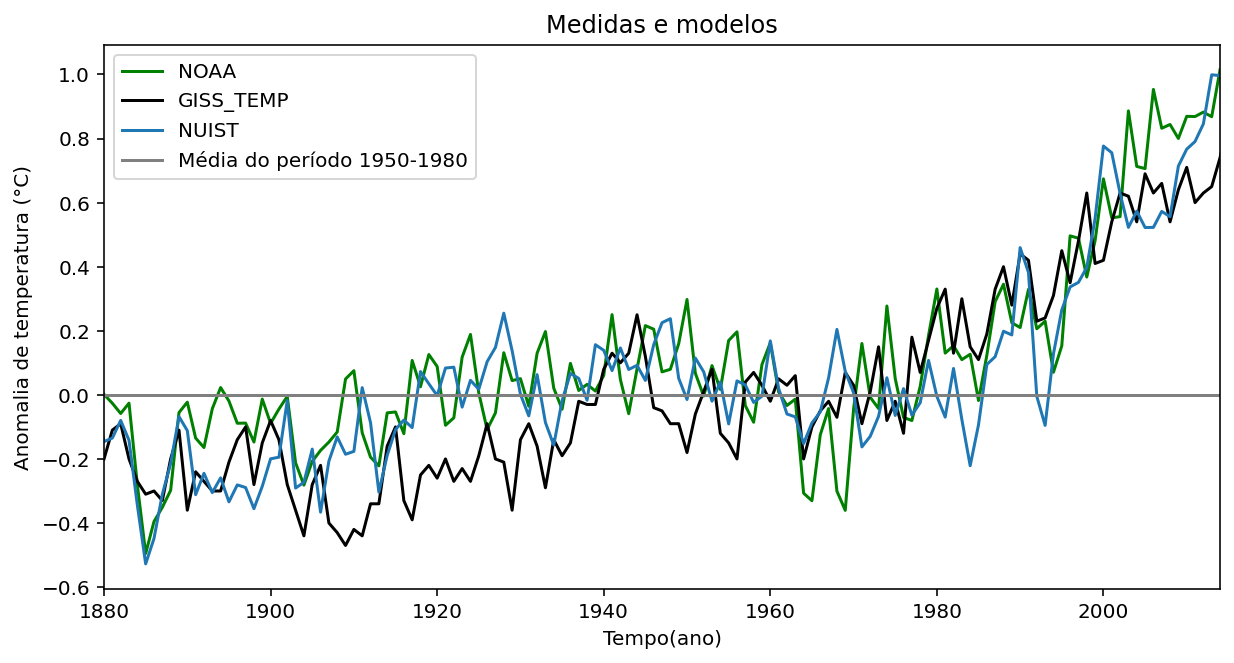

In [10]:
fig = plt.figure(figsize=(10, 5))
plt.plot(xs, ys, c= 'green', label='NOAA')
plt.plot(x, y, c='black',label='GISS_TEMP')
anomalias(NUIST_hist)
plt.xlim(1880, 2014)
plt.axhline(0, color='gray', label='Média do período 1950-1980')   # tente mudar a cor. No entanto, ele só conhece alguns nomes de cores.
plt.title('Medidas e modelos')
plt.xlabel('Tempo(ano)')
plt.ylabel('Anomalia de temperatura (°C)');
plt.legend()

# Aqui vem nossos modelos

## EC-Earth-Consortium e CNRM-CERFACS funcionam com o código a seguir:

In [11]:
MODELO_hist=media12(f"experiment_id == 'historical' & source_id=='{source_id}' & variable_id == 'tas'") 

O código a seguir gerará erros, não se preocupe, siga em frente. (Não o julgue, pois sua vida também não é perfeita)

In [12]:
pd_tas_timeseries=MODELO_hist.tas.to_pandas()
pd_atas_timeseries=pd_tas_timeseries- temperatura(MODELO_hist)
CFTimeIndex=pd_atas_timeseries.index #separação da data no formato CMIP6
# datetimeindex = CFTimeIndex.to_datetimeindex() #Conversão para datatime 
tas_list=pd_atas_timeseries.to_list() #Cria uma lista
new_tas_timeserie=pd.Series(data=tas_list,name='TAS',index=CFTimeIndex) #nova timeserie
new_tas_timeserie_year =new_tas_timeserie.resample("1y").median()
yys=new_tas_timeserie_year.loc['1880-01':'2014-12']
yys=yys.reset_index()
ys=yys['TAS'] #separa a TAS
tempo=yys['index'] #separa a data
xx=tempo.to_list() #coloca em uma lista
xs=np.int16([date.strftime("%Y") for date in tempo.to_list()]).tolist() #pegue apenas o ano e ignore o dia e mês

KeyError: ignored

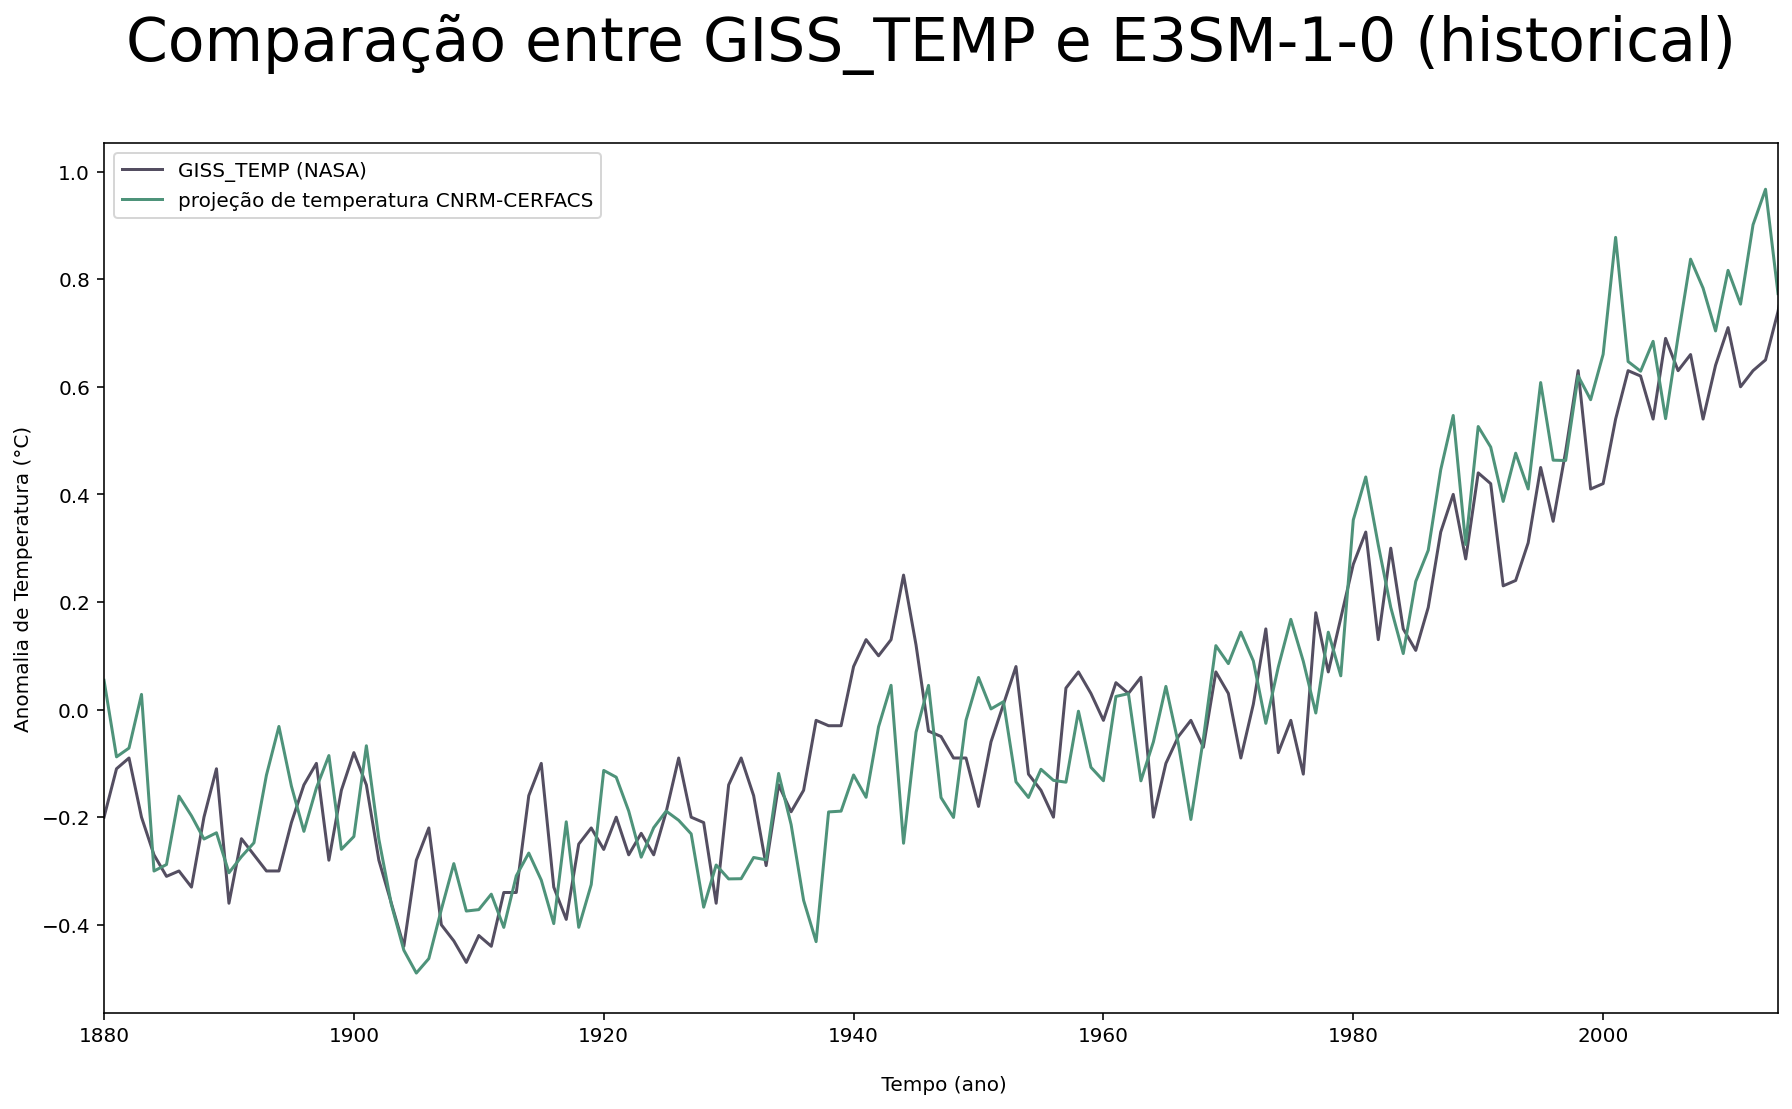

In [13]:
plt.figure(figsize=(15, 8))

# Curvas
plt.plot(x, y, c='#544e61',label='GISS_TEMP (NASA)')
plt.plot(xs, ys, c= '#4e937a', label=f'projeção de temperatura {institution_id}')

# Legendas
plt.title('Comparação entre GISS_TEMP e E3SM-1-0 (historical) \n', fontsize=30)
plt.xlabel('\n Tempo (ano)')
plt.ylabel('Anomalia de Temperatura (°C)')

# Posições e Recortes
plt.legend(loc="upper left")
# plt.ylim(-0.75, 6.75)
plt.xlim(1880, 2014)

# Salvar Imagem
plt.savefig(f'Histórico Temperatura {institution_id}.png', dpi=500, bbox_inches='tight')

## E3SM-Project Funciona com o código a seguir:

In [ ]:
MODELO_hist=media12(f"experiment_id == 'historical' & source_id=='{source_id}' & variable_id == 'tas'")

In [ ]:
pd_tas_timeseries=MODELO_hist.tas.to_pandas()
pd_atas_timeseries=pd_tas_timeseries- temperatura(MODELO_hist)
CFTimeIndex=pd_atas_timeseries.index #separação da data no formato CMIP6
datetimeindex=CFTimeIndex.to_datetimeindex() #Conversão para datatime                    EC e CN comente essa linha.
tas_list=pd_atas_timeseries.to_list() #Cria uma lista
new_tas_timeserie=pd.Series(data=tas_list,name='TAS',index=datetimeindex) #nova timeserie           # EC e CN use index=CFTimeIndex Vai da erro mais dá certo.
new_tas_timeserie_year =new_tas_timeserie.resample("1y").median()
yys=new_tas_timeserie_year.loc['1880-01':'2014-12']
yys=yys.reset_index()
ys=yys['TAS'] #separa a TAS
tempo=yys['index'] #separa a data
xx=tempo.to_list() #coloca em uma lista
xs=np.int16([date.strftime("%Y") for date in xx]).tolist() #pegue apenas o ano e ignore o dia e mês

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  after removing the cwd from sys.path.


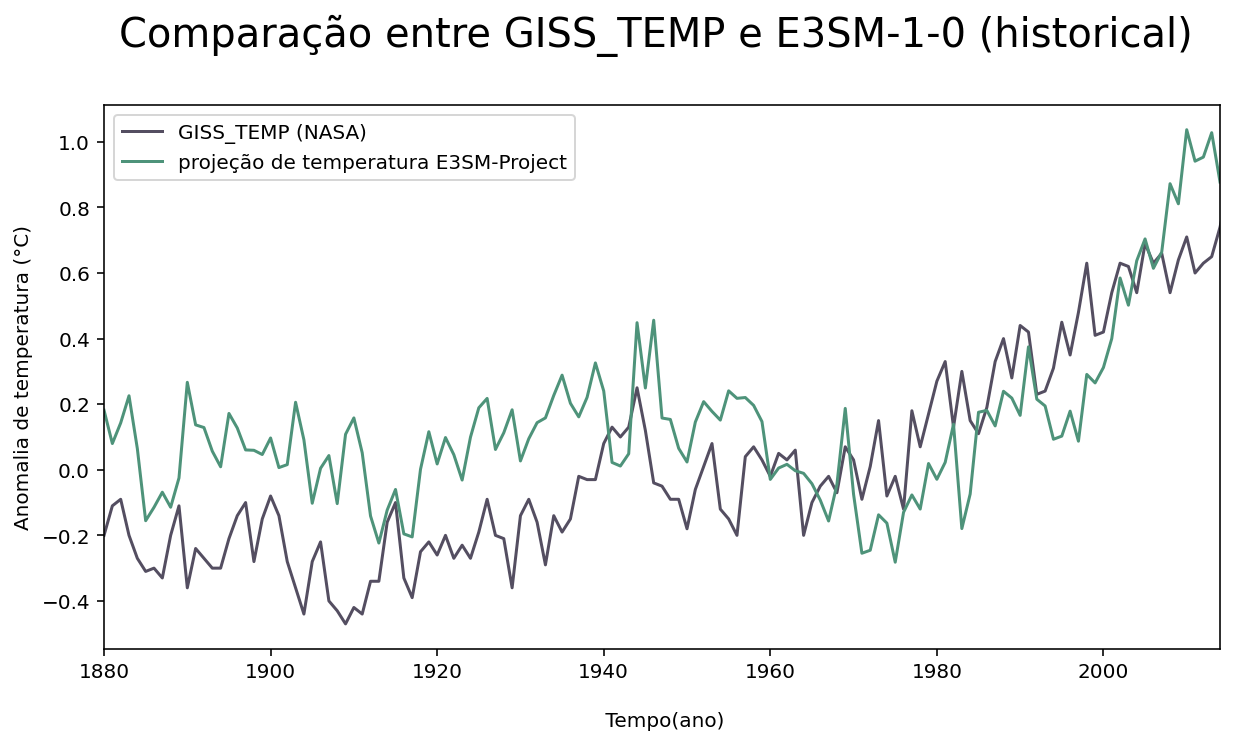

In [ ]:
plt.figure(figsize=(15, 8))

# Curvas
plt.plot(x, y, c='#544e61',label='GISS_TEMP (NASA)')
plt.plot(xs, ys, c= '#4e937a', label=f'projeção de temperatura {institution_id}')

# Legendas
plt.title('Comparação entre GISS_TEMP e E3SM-1-0 (historical) \n', fontsize=30)
plt.xlabel('\n Tempo (ano)')
plt.ylabel('Anomalia de Temperatura (°C)')

# Posições e Recortes
plt.legend(loc="upper left")
# plt.ylim(-0.75, 6.75)
plt.xlim(1880, 2014)

# Salvar Imagem
plt.savefig(f'Histórico Temperatura {institution_id}.png', dpi=500, bbox_inches='tight')